# original

100
200
300
400
500
600
700
800
900
1000


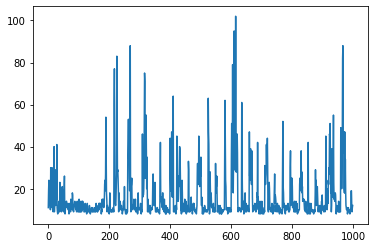

In [1]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt


class Model():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim]),
        ])
    
    def predict(self, state):
        state = state.reshape(1, self.input_dim)
        return self.network(state).numpy()
    
class Agent():
    def __init__(self, input_dim, output_dim):
        self.model = Model(input_dim, output_dim)
        self.epsilon = 0.90
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.05
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self, state, next_state, reward, done):
        if done:
            target = reward
        else:
            target = reward + np.max(self.model.predict(next_state)[0])

        target_full = self.model.predict(state)
        target_full[0, np.argmax(self.model.predict(next_state)[0])] = target

        with tf.GradientTape() as tape:
            tape.watch(self.model.network.trainable_variables)
            loss = tf.reduce_mean(tf.square(target_full - self.model.network(state.reshape(1, 4))))
        gradients = tape.gradient(loss, self.model.network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.network.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        rewards_collect += 1
        agent.learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.90)
agent = Agent(4, 2)

sum_rewards = []
for t in range(1000):
    sum_rewards.append(play_one_episode())
    if (t+1) % 100 == 0:
        print(t+1)
        
plt.plot(sum_rewards)
plt.show()

# gradienten der batch-items werden einzeln angewendet

- Bei kleineren Lernraten kommt es zu Konvergenz, aber evtl. instabiler als bei größeren Lernraten.   
- Nicht jede Neuinitialisierung bringt Konvergenz
- Verhältnis batch_size - lernrate ist sehr empfindlich
- Bei gleichen settings ist clever = False besser(?) 

10 :  29
20 :  200
30 :  9
40 :  10
50 :  8
60 :  200
70 :  200
80 :  200
90 :  200
100 :  9
110 :  10
120 :  200
130 :  200
140 :  200
150 :  200
Dauer: 106.93


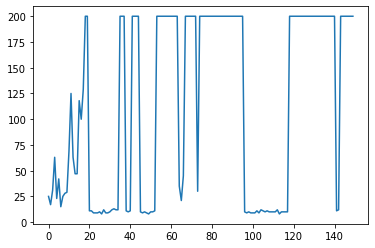

In [2]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt
from collections import deque
import time

class Model():
    def __init__(self, input_dim, output_dim, clever = True):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.clever = clever
        if self.clever:
            self.network = tf.keras.Sequential([
                tf.keras.layers.Dense(units= 24, activation = 'relu', input_shape = [self.input_dim]),
                tf.keras.layers.Dense(units= 24, activation = 'relu'),
                tf.keras.layers.Dense(self.output_dim, activation = 'linear'),
            ])
        else:
            self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim]),
        ])
    
    def predict(self, state):
        state = state.reshape(1, self.input_dim)
        return self.network(state).numpy()
            
class Agent():
    def __init__(self, input_dim, output_dim, clever):
        self.model = Model(input_dim, output_dim, clever)
        self.epsilon = 0.90
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.05
        self.memory = deque()
        self.batch_size = 10
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self, state, next_state, reward, done):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in batch:
            if done:
                target = reward
            else:
                target = reward + np.max(self.model.predict(next_state)[0])

            target_full = self.model.predict(state)
            target_full[0, np.argmax(self.model.predict(next_state)[0])] = target

            with tf.GradientTape() as tape:
                tape.watch(self.model.network.trainable_variables)
                loss = tf.reduce_mean(tf.square(target_full - self.model.network(state.reshape(1, 4))))
            gradients = tape.gradient(loss, self.model.network.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.network.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
                
def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.memory.append((state, action, reward, next_state))
        rewards_collect += 1
        if len(agent.memory) > agent.batch_size and np.random.rand()<.3:
            agent.learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.Adam(learning_rate = .075)
agent = Agent(4, 2, False)

t0 = time.time()
sum_rewards = []
for t in range(150):
    Return = play_one_episode()
    sum_rewards.append(Return)
    if (t+1) % 10 == 0:
        print(t+1,': ', Return)
plt.plot(sum_rewards)
t1 = time.time()
print('Dauer:', round(t1-t0,2))

# mit batch gradienten (gemittelt über batch)

- kleinerer Batch -> kleinere Lernrate (oder auch nicht???)

In [3]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt
from collections import deque
from tqdm import tqdm
import time

5 :  26
10 :  22
15 :  22
20 :  12
25 :  67
30 :  35
35 :  17
40 :  23
45 :  14
50 :  28
55 :  58
60 :  35
65 :  55
70 :  69
75 :  43
80 :  65
85 :  52
90 :  69
95 :  135
100 :  47
105 :  123
110 :  81
115 :  39
120 :  41
125 :  49
130 :  162
135 :  44
140 :  97
145 :  189
150 :  109
155 :  129
160 :  178
165 :  105
170 :  50
175 :  139
180 :  115
185 :  80
190 :  183
195 :  49
200 :  71
205 :  73
210 :  100
215 :  200
220 :  61
225 :  57
230 :  200
235 :  200
240 :  150
245 :  112
250 :  92
255 :  200
260 :  200
265 :  200
270 :  200
275 :  200
280 :  200
285 :  200
290 :  200
295 :  200
300 :  200
305 :  200
310 :  200
315 :  200
320 :  200
325 :  200
330 :  200
335 :  200
340 :  200
345 :  200
350 :  200
355 :  200
360 :  200
365 :  200
370 :  200
375 :  200
380 :  200
385 :  200
390 :  200
395 :  200
400 :  200
Dauer: 543.7


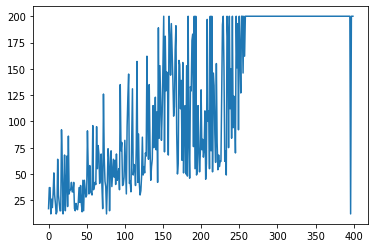

In [4]:
class Model():
    def __init__(self, input_dim, output_dim, clever = True):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.clever = clever
        if self.clever:
            self.network = tf.keras.Sequential([
                tf.keras.layers.Dense(units= 24, activation = 'relu', input_shape = [self.input_dim]),
                tf.keras.layers.Dense(units= 24, activation = 'relu'),
                tf.keras.layers.Dense(self.output_dim, activation = 'linear'),
            ])
        else:
            self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim]),
        ])
    
    def predict(self, state):
        state = state.reshape(1, self.input_dim)
        return self.network(state).numpy()
    
class Agent():
    def __init__(self, input_dim, output_dim, clever):
        self.model = Model(input_dim, output_dim, clever)
        self.epsilon = 0.99
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.05
        self.gamma = .99
        self.memory = deque()
        self.batch_size = 32
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self, state, next_state, reward, done):

        if done:
            target = reward
        else:
            target = reward + np.max(self.model.predict(next_state)[0])

        target_full = self.model.predict(state)
        target_full[0, np.argmax(self.model.predict(next_state)[0])] = target

        with tf.GradientTape() as tape:
            tape.watch(self.model.network.trainable_variables)
            loss = tf.reduce_mean(tf.square(target_full - self.model.network(state.reshape(1, 4))))
        gradients = tape.gradient(loss, self.model.network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.network.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def batch_learn(self, state, next_state, reward, done):
        
        batch = random.sample(self.memory, self.batch_size)
        
        train_vars = self.model.network.trainable_variables
       
        accum_gradient = [tf.zeros_like(el) for el in train_vars]
        
        for state, action, reward, next_state in batch:
            if done:
                target = reward
            else:
                target = reward + np.max(self.model.predict(next_state)[0])

            target_full = self.model.predict(state)
            target_full[0, np.argmax(self.model.predict(next_state)[0])] = target

            with tf.GradientTape() as tape:
                tape.watch(self.model.network.trainable_variables)
                loss = tf.reduce_mean(tf.square(target_full - self.model.network(state.reshape(1, 4))))
            
            gradients = tape.gradient(loss, train_vars)
            accum_gradient = [(acg+grad) for acg, grad in zip(accum_gradient, gradients)]

        accum_gradient = [curr_grad/self.batch_size for curr_grad in accum_gradient]

            
        optimizer.apply_gradients(zip(accum_gradient, train_vars))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    for i in range(max_iter):
        #if i % 20 == 0:
        #    agent.batch_size += 10
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        rewards_collect += 1
        if done:
        #    if i != 199:
        #        reward -= 5
        #        agent.memory.append((state, action, reward, next_state))
        #    if i == 200:
        #        print('win')
            break
        agent.memory.append((state, action, reward, next_state))
        #rewards_collect += 1
        if len(agent.memory) > agent.batch_size and np.random.rand() < .25:
            agent.batch_learn(state, next_state, reward, done)
        #else: 
        #    agent.learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #0.075
agent = Agent(4, 2, clever=False)

t0 = time.time()
max_iter = 200
sum_rewards = []
for t in range(400):
    Return = play_one_episode()
    sum_rewards.append(Return)
    if (t+1) % 5 == 0:
        print(t+1,': ', Return)
        
t1 = time.time()
        
plt.plot(sum_rewards)
print('Dauer:', round(t1-t0,2))

# einzelne gradienten aus batch mit model.fit statt gradient tape

- dauert länger als gradient Tape

In [2]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt
from collections import deque

In [ ]:
LEARNING_RATE = 0.075

class Agent():
    def __init__(self, input_dim, output_dim, clever = True):
        self.model = self.make_model(input_dim, output_dim, clever)
        self.epsilon = 0.9
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.05
        self.gamma = .99
        self.memory = deque()
        self.batch_size = 10

        
    def make_model(self, input_dim, output_dim, clever):
        if clever:
            mod = tf.keras.Sequential([
                    tf.keras.layers.Dense(units= 24, activation = 'relu', input_shape = [input_dim,]),
                    tf.keras.layers.Dense(units= 24, activation = 'relu'),
                    tf.keras.layers.Dense(output_dim, activation = 'linear'),
                ])
            mod.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='mse')
            return mod    
        
        else:
            mod = tf.keras.Sequential([
                tf.keras.layers.Dense(input_shape = [input_dim,], units = output_dim, activation = 'linear'),
            ])
            mod.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='mse')
            return mod  
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))

    def batch_learn(self, state, next_state, reward, done):
        
        batch = random.sample(self.memory, self.batch_size)
        batch_observations = []  
        batch_targets = []
        
        for state, action, reward, next_state in batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.model.predict(next_state)[0])

            Q_values = self.model.predict(state)
            Q_values[0, action] = target
            self.model.fit(state, Q_values, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    while not done:
        state = state.reshape([-1,4])
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape([-1,4])
        agent.memory.append((state, action, reward, next_state))
        rewards_collect += 1
        if len(agent.memory) > agent.batch_size:
            agent.batch_learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
agent = Agent(4, 2, False)

play_one_episode()

sum_rewards = []
for t in range(200):
    Return = play_one_episode()
    sum_rewards.append(Return)
    if (t+1) % 1 == 0:
        print(t+1,': ', Return)
        
plt.plot(sum_rewards)
plt.show()

1 :  20
2 :  11
3 :  9
4 :  12
5 :  15
6 :  13
7 :  17
8 :  12
9 :  10
10 :  19
11 :  10
12 :  8
13 :  9
14 :  11
15 :  9
16 :  12
17 :  11
18 :  8
19 :  10
20 :  8
21 :  9
22 :  10
23 :  10
24 :  11
25 :  12
26 :  10
27 :  10
28 :  10
29 :  9
30 :  9
31 :  10
32 :  8
33 :  8
34 :  9
35 :  9
36 :  10
37 :  11
38 :  10
39 :  11
40 :  9
41 :  11
42 :  12
43 :  10
44 :  10
45 :  12
46 :  11
47 :  10
48 :  12
49 :  14
50 :  17
51 :  13
52 :  18
53 :  10
54 :  8
55 :  13
56 :  15
57 :  34
58 :  10
59 :  9
60 :  9
61 :  10
62 :  12
63 :  8
64 :  12
65 :  12
66 :  12
67 :  13
68 :  21
69 :  11
70 :  10
71 :  10
72 :  12
73 :  11
74 :  13
75 :  13
76 :  10
77 :  9
78 :  10
79 :  11
80 :  8
81 :  9
82 :  10
83 :  10
84 :  9
85 :  10
86 :  9
87 :  10
88 :  9
89 :  9
90 :  11
91 :  13
92 :  14
93 :  13
94 :  12
95 :  10
96 :  9
97 :  15
98 :  10
99 :  9
100 :  8
101 :  11
102 :  11
103 :  10
104 :  14
105 :  12
106 :  9
107 :  12
108 :  12
109 :  10
110 :  11
111 :  11
112 :  12
113 :  11
114 :  

# Batch mit model.fit statt gradient tape 
https://github.com/VBot2410/Deep-Q-Learning-Cartpole/blob/master/Cartpole%20Deep%20Q-Learning.ipynb 

In [1]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt
from collections import deque

1 :  15
2 :  21
3 :  21
4 :  10
5 :  30
6 :  18
7 :  25
8 :  16
9 :  27
10 :  15
11 :  25
12 :  14
13 :  14
14 :  13
15 :  15
16 :  20
17 :  17
18 :  16
19 :  14
20 :  21
21 :  23
22 :  11
23 :  14
24 :  11
25 :  14
26 :  10
27 :  19
28 :  30
29 :  11
30 :  12
31 :  10
32 :  25
33 :  50
34 :  26
35 :  43
36 :  25
37 :  12
38 :  17
39 :  17
40 :  18
41 :  16
42 :  10
43 :  23
44 :  25
45 :  19
46 :  14
47 :  22
48 :  14
49 :  13
50 :  12
51 :  19
52 :  24
53 :  18
54 :  9
55 :  12
56 :  27
57 :  17
58 :  10
59 :  16
60 :  13
61 :  11
62 :  13
63 :  10
64 :  9
65 :  39
66 :  14
67 :  27
68 :  11
69 :  15
70 :  21
71 :  16
72 :  13
73 :  12
74 :  18
75 :  18
76 :  10
77 :  12
78 :  10
79 :  12
80 :  9
81 :  12
82 :  18
83 :  13
84 :  12
85 :  14
86 :  17
87 :  13
88 :  16
89 :  18
90 :  11
91 :  15
92 :  32
93 :  11
94 :  12
95 :  21
96 :  11
97 :  15
98 :  25
99 :  13
100 :  13


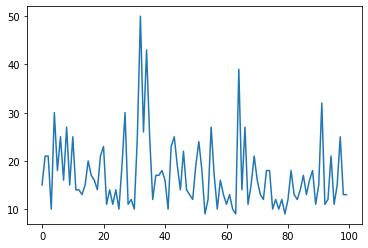

In [2]:
LEARNING_RATE = 0.1
class Agent():
    def __init__(self, input_dim, output_dim, clever = True):
        self.model = self.make_model(input_dim, output_dim, clever)
        self.epsilon = 0.99
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.05
        self.gamma = .99
        self.memory = deque()
        self.batch_size = 10

        
    def make_model(self, input_dim, output_dim, clever):
        if clever:
            mod = tf.keras.Sequential([
                    tf.keras.layers.Dense(units= 24, activation = 'relu', input_shape = [input_dim,]),
                    tf.keras.layers.Dense(units= 24, activation = 'relu'),
                    tf.keras.layers.Dense(output_dim, activation = 'linear'),
                ])
            mod.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='mse')
            return mod    
        
        else:
            mod = tf.keras.Sequential([
                tf.keras.layers.Dense(input_shape = [input_dim,], units = output_dim, activation = 'linear'),
            ])
            mod.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='mse')
            return mod     
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))

    def batch_learn(self, state, next_state, reward, done):
        
        batch = random.sample(self.memory, self.batch_size)
        batch_observations = []  
        batch_targets = []
        
        for state, action, reward, next_state in batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.model.predict(next_state))

            Q_values = self.model.predict(state)
            Q_values[0, action] = target
            
            batch_observations.append(state)
            batch_targets.append(Q_values)
            
        batch_observations = np.reshape(batch_observations, [-1,4])
        batch_targets = np.reshape(batch_targets, [-1,2])
#        print(batch_targets)
        self.model.fit(batch_observations, batch_targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def play_one_episode():
    state = env.reset()
    rewards_collect = 0
    done = False
    while not done:
        state = state.reshape([-1,4])
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape([-1,4])
        agent.memory.append((state, action, reward, next_state))
        rewards_collect += 1
        if len(agent.memory) > agent.batch_size and np.random.rand() < .3:
            agent.batch_learn(state, next_state, reward, done)
        state = next_state
    
    return rewards_collect

env = gym.make('CartPole-v0')
agent = Agent(4, 2, False)

play_one_episode()

sum_rewards = []
for t in range(100):
    Return = play_one_episode()
    sum_rewards.append(Return)
    if (t+1) % 1 == 0:
        print(t+1,': ', Return)
        
plt.plot(sum_rewards)
plt.show()